### Package Import

package info
* Pydot 1.4.1 
* Pandas 0.25.0
* Networkx 1.9
* matplotlib 2.2.3
* nxpd 0.2.0

In [1]:
import json
import copy
from IPython.display import Image

import pydot
import pandas as pd
import networkx as nx
from nxpd import draw, nxpdParams
from matplotlib import pyplot as plt

# if you encountered the error "graphviz's executables not found" please use "brew install graphviz"

### Function Definition

In [2]:
# turn all the values into str
def value_to_str(dict_name):
    for k, v in dict_name.items():
        if type(v) == type({}):
            value_to_str(v)
        else:
            dict_name[k] = str(v)


def assign_id(js_dict):
    value_to_str(js_dict)  # change all values to str
    new_js_dict = {}
    new_js_dict[
        "Start"] = js_dict  # create a new root to ensure the graph looks nice
    num = 0
    add_num(new_js_dict)  # add num tag
    return (new_js_dict)


def add_num(
        dict_name):  # add number to each k or v which will be treated as id
    global num
    for k in list(dict_name.keys()):
        v = dict_name[k]
        dict_name[k + "__" + str(num)] = dict_name.pop(k)
        if type(v) == type({}):
            num = num + 1
            add_num(v)
        else:
            dict_name[k + "__" + str(num)] = str(v) + "__" + str(num + 1)
            num = num + 2


def edge_eda(dict_name, tag_num=0):  # all edge data "A--B"
    global edge_lst
    for k, v in dict_name.items():

        sta_id = k.split("__")[1]
        sta_lab = k.split("__")[0]

        if type(v) == type({}):
            for key in list(v.keys()):
                end_id = key.split("__")[1]
                end_lab = key.split("__")[0]

                edge_lst.append([sta_id, sta_lab, end_id, end_lab])
            edge_eda(v)
        else:
            end_id = v.split("__")[1]
            end_lab = v.split("__")[0]
            edge_lst.append([sta_id, sta_lab, end_id, end_lab])
    return (pd.DataFrame(edge_lst))


def id_label(new_js_dict):  # create dict for easy search id<-->label
    global edge_lst
    edge_lst = []
    tag_num = 0
    edge_ = edge_eda(new_js_dict)

    id_label_dict = {}
    edge_dict = {}
    for row in range(len(edge_)):
        id_label_dict[edge_.iloc[row, 0]] = edge_.iloc[row, 1]
        id_label_dict[edge_.iloc[row, 2]] = edge_.iloc[row, 3]
        edge_dict[row] = [edge_.iloc[row, 0], edge_.iloc[row, 2]]
    return (id_label_dict, edge_dict)


def attr_lst(G, id_label_dict,
             attr_set):  #based on the definition, find out all attributes
    attr_ = []
    for node_id in list(id_label_dict.keys()):
        par_set = set(
            [id_label_dict[suc_id] for suc_id in G.successors(node_id)])
        if set(attr_set).issubset(par_set):
            attr_.append(node_id)
            pre_id = G.predecessors(node_id)
            if len(pre_id) == 1 and pre_id[0] not in attr_:
                attr_.append(pre_id[0])
    return (attr_)


nxpdParams['show'] = 'ipynb'


def draw_graph(id_label_dict, edge_dict, attr_set, sub_attr_set,
               const_attr_set):
    G = nx.DiGraph()
    for k, v in id_label_dict.items():
        G.add_node(k, {'label': v})
    for k, v in edge_dict.items():
        G.add_edge(v[0], v[1])
    draw(G)
    attr_lst_r = attr_lst(
        G, id_label_dict,
        attr_set)  # store nodes with certain structure (title, type)

    attr_succ_id = []
    for attr_id in attr_lst_r:
        for attr_suc_id in G.successors(attr_id):
            if id_label_dict[attr_suc_id] in sub_attr_set:
                attr_succ_id.append(attr_suc_id)

    attr_cons_id = []
    for attr_id in attr_lst_r:
        for attr_suc_id in G.successors(attr_id):
            if id_label_dict[attr_suc_id] in const_attr_set:
                attr_cons_id.append(attr_suc_id)

    G1 = nx.DiGraph()
    for k, v in id_label_dict.items():
        if k in attr_lst_r:
            G1.add_node(k, {'label': v}, style="filled",
                        fillcolor='#FF8080')  #attribute --> read
        elif k in attr_succ_id:
            G1.add_node(k, {'label': v}, style="filled",
                        fillcolor='#80FF80')  # sub-features --> green
        elif k in attr_cons_id:
            G1.add_node(k, {'label': v}, style="filled",
                        fillcolor='#efa8e4')  # sub-features --> green
        else:
            G1.add_node(k, {'label': v}, style="filled", fillcolor="white")
    for k, v in edge_dict.items():
        G1.add_edge(v[0], v[1])
    return (G1)

### Raw JSON to Dict

In [3]:
# ! git clone https://github.com/data-exp-lab/analysis_schema.git

#### from existed json file

In [4]:
v='UnitfulCoordinate'
# v='UnitfulArray'
# v='UnitfulValue'
# v='Sphere'
# v='image_gallery'
with open("js_file/" + v + ".json") as f:
    js_dict = json.load(f)

In [5]:
js_dict

{'title': 'UnitfulCoordinate',
 'type': 'object',
 'properties': {'values': {'title': 'Values',
   'default': [0.5, 0.5, 0.5],
   'minItems': 3,
   'maxItems': 3,
   'type': 'array',
   'items': {'type': 'number'}},
  'unit': {'title': 'Unit', 'default': 'unitary', 'type': 'string'}}}

In [6]:
js_dict_sta = {}
js_dict_sta["Start"] = copy.deepcopy(js_dict)

#### assign id to every artifact

In [7]:
num = 0
new_js_dict = assign_id(js_dict)

In [8]:
new_js_dict

{'Start__0': {'title__1': 'UnitfulCoordinate__2',
  'type__3': 'object__4',
  'properties__5': {'values__6': {'title__7': 'Values__8',
    'default__9': '[0.5, 0.5, 0.5]__10',
    'minItems__11': '3__12',
    'maxItems__13': '3__14',
    'type__15': 'array__16',
    'items__17': {'type__18': 'number__19'}},
   'unit__20': {'title__21': 'Unit__22',
    'default__23': 'unitary__24',
    'type__25': 'string__26'}}}}

### Draw Graph

definition of nodes and sub-nodes

In [9]:
attr_set = set(
    ["title"]
)  #definition of attributes (e.g. here means the node must contain title and type)
sub_attr_set = ["title", "items",
                "default"]  # descendants which can be transformed into blocks
const_attr_set = ["type"]  #

In [10]:
id_label_dict, edge_dict = id_label(new_js_dict)

In [11]:
#id_label_dict

In [12]:
#edge_dict

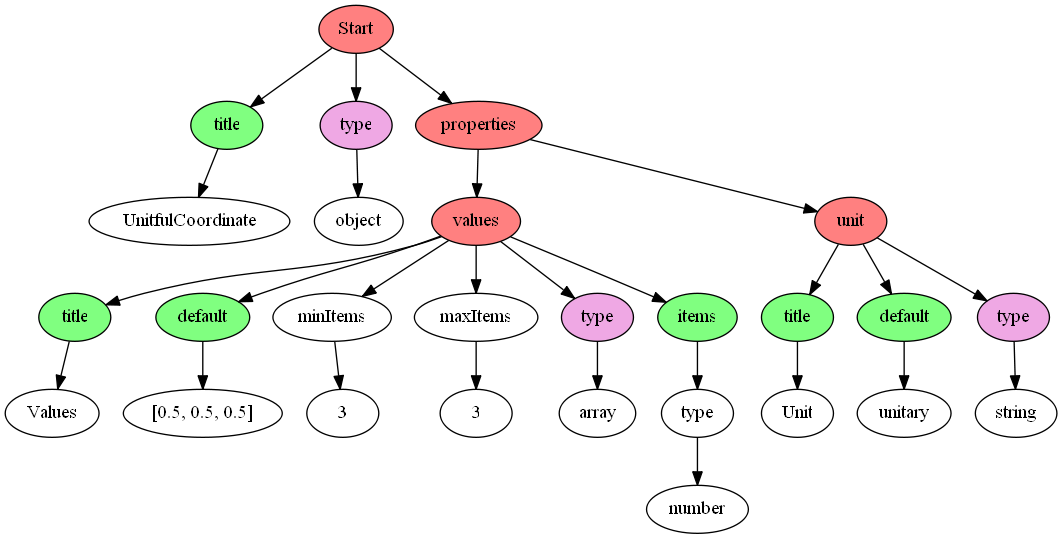

In [13]:
G = draw_graph(id_label_dict, edge_dict, attr_set, sub_attr_set,
               const_attr_set)
draw(G)

In [14]:
# nxpdParams['show'] = 'ipynb'
# G_rl = nx.DiGraph()
# G_rl.add_node(0, {'label' : "object"},style="filled", fillcolor='#FF8080')
# G_rl.add_node(1, {'label' : "attribute1"},style="filled", fillcolor='#80FF80') 
# G_rl.add_node(2, {'label' : "attribute2"},style="filled", fillcolor='#80FF80') 
# G_rl.add_node(3, {'label' : "..."},style="filled", fillcolor='white')
# G_rl.add_edge(0,1)
# G_rl.add_edge(0,2)
# G_rl.add_edge(0,3)
# draw(G_rl)

In [15]:
# nxpdParams['show'] = 'ipynb'
# G_rl = nx.DiGraph()
# G_rl.add_node(0, {'label' : "properties"},style="filled", fillcolor='#FF8080') 
# G_rl.add_node(1, {'label' : "values"},style="filled", fillcolor='#FF8080') 
# G_rl.add_node(2, {'label' : "unit"},style="filled", fillcolor='#FF8080') 

# # G_rl.add_node(4, {'label' : "feature1"},style="filled", fillcolor='#80FF80') 
# # G_rl.add_node(5, {'label' : "feature2"},style="filled", fillcolor='#80FF80') 
# # G_rl.add_node(6, {'label' : "..."},style="filled", fillcolor='white')

# # G_rl.add_node(7, {'label' : "feature1"},style="filled", fillcolor='#80FF80') 
# # G_rl.add_node(8, {'label' : "feature2"},style="filled", fillcolor='#80FF80')
# # G_rl.add_node(9, {'label' : "..."},style="filled", fillcolor='white')

# G_rl.add_edge(0,1)
# # G_rl.add_edge(1,4)
# # G_rl.add_edge(1,5)
# # G_rl.add_edge(1,6)
# G_rl.add_edge(0,2)
# # G_rl.add_edge(2,7)
# # G_rl.add_edge(2,8)
# # G_rl.add_edge(2,9)
# draw(G_rl)

In [16]:
# nxpdParams['show'] = 'ipynb'
# G_rl = nx.DiGraph()
# G_rl.add_node(0, {'label' : "object"},style="filled", fillcolor='#FF8080')
# G_rl.add_node(1, {'label' : "attribute1"},style="filled", fillcolor='#80FF80') 
# G_rl.add_node(2, {'label' : "attribute2"},style="filled", fillcolor='#80FF80') 
# G_rl.add_node(3, {'label' : "..."},style="filled", fillcolor='white')

# G_rl.add_node(4, {'label' : "object"},style="filled", fillcolor='#FF8080')
# G_rl.add_node(5, {'label' : "..."},style="filled", fillcolor='#FF8080')

# G_rl.add_edge(0,1)
# G_rl.add_edge(0,2)
# G_rl.add_edge(0,3)
# G_rl.add_edge(0,4)
# G_rl.add_edge(0,5)
# draw(G_rl)

In [17]:
# nxpdParams['show'] = 'ipynb'
# G_rl = nx.DiGraph()
# G_rl.add_node(0, {'label' : "start"},style="filled", fillcolor='#FF8080')
# G_rl.add_node(1, {'label' : "title"},style="filled", fillcolor='#80FF80') 
# G_rl.add_node(2, {'label' : "type"},style="filled", fillcolor='#80FF80') 
# G_rl.add_node(3, {'label' : "UnitfulCoordinate"},style="filled", fillcolor='white')
# G_rl.add_node(4, {'label' : "Object"},style="filled", fillcolor='white')
# G_rl.add_node(5, {'label' : "properties"},style="filled", fillcolor='#FF8080')

# G_rl.add_edge(0,1)
# G_rl.add_edge(0,2)
# G_rl.add_edge(1,3)
# G_rl.add_edge(2,4)
# G_rl.add_edge(0,5)
# draw(G_rl)

### Generate block Define JSON

In [18]:
js_dict_sta  # current dict

{'Start': {'title': 'UnitfulCoordinate',
  'type': 'object',
  'properties': {'values': {'title': 'Values',
    'default': [0.5, 0.5, 0.5],
    'minItems': 3,
    'maxItems': 3,
    'type': 'array',
    'items': {'type': 'number'}},
   'unit': {'title': 'Unit', 'default': 'unitary', 'type': 'string'}}}}

In [19]:
def gen_node_dict(G, node_id, id_label_dict, attr_node_ids):
    node_dict = {}
    input_val_list = []
    for id_ in G.successors(node_id):
        if G.node[id_]["label"] == "title":
            node_dict["title"] = id_label_dict[G.successors(id_)[0]]
        if G.node[id_]["label"] == "type":
            node_dict["type"] = id_label_dict[G.successors(id_)[0]]
        if G.node[id_]["label"] == "items":
            node_dict["items_type"] = id_label_dict[G.successors(
                G.successors(id_)[0])[0]]
        if G.node[id_]["label"] == "default":
            node_dict["default"] = id_label_dict[G.successors(id_)[0]]
        if id_ in attr_node_ids:
            input_val_list.append(id_)
    if "title" not in node_dict.keys():
        node_dict["title"] = G.node[node_id]["label"]
    if "type" not in node_dict.keys():
        node_dict["type"] = G.node[node_id]["label"]

    input_val_dict = {}
    for input_val_id in input_val_list:
        sub_node = {}
        sub_node_label = G.node[input_val_id]["label"]
        for id_ in G.successors(input_val_id):
            if G.node[id_]["label"] == "title":
                sub_node["name"] = id_label_dict[G.successors(id_)[0]]
            if G.node[id_]["label"] == "type":
                sub_node["type"] = id_label_dict[G.successors(id_)[0]]

        if "name" not in sub_node.keys():
            sub_node["name"] = G.node[input_val_id]["label"]
        if "type" not in sub_node.keys():
            sub_node["type"] = G.node[input_val_id]["label"]

        input_val_dict[sub_node_label] = sub_node

    if len(input_val_list) > 0:
        node_dict["sub_node"] = input_val_dict

    return (node_dict)

In [20]:
attr_node_ids = attr_lst(G, id_label_dict, attr_set)
attr_node_ids  # get the red_node in order to generate corresponded blocks

['0', '6', '5', '20']

In [21]:
gen_node_dict(G, "6", id_label_dict,
               attr_node_ids)

{'title': 'Values',
 'default': '[0.5, 0.5, 0.5]',
 'type': 'array',
 'items_type': 'number'}

**update field_variable / input_value / field_input / field_num**

In [22]:
def bl_js_ge(G, attr_id, id_label_dict, attr_node_ids):

    node_own_dict = gen_node_dict(G, attr_id, id_label_dict, attr_node_ids)

    field_var = {
        "type": "field_variable",
        "name": "default",
        "variable": "default"
    }
    input_val = {"type": "input_value", "name": "default", "check": "default"}
    field_input = {"type": "field_input", "name": "default", "text": "default"}
    field_num = {"type": "field_number", "name": "default", "value": 0}

    block_args = []

    #update field variable
    attr_title = node_own_dict["title"]
    field_var["name"] = attr_title
    field_var["variable"] = attr_title
    block_args.append(field_var)

    #update input_value
    if "sub_node" in node_own_dict.keys():
        for attr_op_item in node_own_dict["sub_node"].keys():
            input_val["name"] = node_own_dict["sub_node"][attr_op_item]["name"]
            input_val["check"] = node_own_dict["sub_node"][attr_op_item][
                "type"]
            block_args.append(input_val)

    #update field_input
    
    
    
    

    # update block type
    block_type = node_own_dict["type"]

    #update block format
    block_format = 'set %1 to'
    if len(block_args) > 0:
        for num in range(1, len(block_args)):
            block_format = block_format + " %" + str(num + 1)

    block_dict = {
        "message0": block_format,
        "args0": block_args,
        "inputsInline": "true",
        "output": block_type,
        "colour": 230,
    }

    block_def = "var " + attr_title + "=" + str(block_dict) + ";"
    block_fun = '''Blockly.Blocks['%s'] = {init: function() {this.jsonInit(%s);}};''' % (
        attr_title, attr_title)
    block_js = block_def + block_fun

    xml_js = '''<block type="%s"></block>''' % (attr_title)

    return (xml_js, block_js)

### Generate block define JSON

In [23]:
# attr_node_ids

In [24]:
xml_js = ''
block_js = ''
for id_ in attr_node_ids:
    xml_, block_ = bl_js_ge(G, id_, id_label_dict, attr_node_ids)
    xml_js = xml_js + xml_
    block_js = block_js + block_

In [25]:
#xml_js

In [26]:
#block_js

### Show blocks

Please put blockly_compressed.js, blocks_compressed.js, en.js under the same directory

In [27]:
wrapper = '''
<head>
<meta charset="utf-8">
<script src="./blockly_compressed.js"></script>
<script src="./blocks_compressed.js"></script>
<script src="./en.js"></script>
</head>

<body>
<div id="blocklyDiv" style="height: 480px; width: 800px;"></div>

<xml id="toolbox" style="display: none">
%s
</xml>

<script>   
%s

var workspace = Blockly.inject('blocklyDiv',
{toolbox: document.getElementById('toolbox')});
</script>

</body>
'''
wrapper = wrapper % (xml_js, block_js)

In [28]:
from IPython.display import HTML
HTML(wrapper)

In [29]:
# #button import
# def import_json():
#     file_path = filedialog.askopenfilename()
#     with open(file_path) as f:
#         js_dict = json.load(f)

In [30]:
# import tkinter as tk
# from tkinter import filedialog

# window = tk.Tk()
# window.title('JSON2Blockly')
# window.geometry('1200x800')
# b = tk.Button(window, text='import JSON file', font=('Arial', 12), width=50, height=1, command=import_json)
# b.pack()
# window.mainloop()